In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
import cartopy.crs as ccrs
import os
import datetime
from datetime import timedelta
from datetime import datetime
from matplotlib import ticker
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import geopandas as gp
import regionmask
import matplotlib.patheffects as pe
import pooch
from matplotlib.lines import Line2D
from scipy import stats

In [2]:
def remove_time_mean(x):
    return x - x.mean(dim='time')

def standardize(x):
    return x/x.std(dim = 'time')

In [3]:
import datetime
from dateutil.parser import parse

In [4]:
# ID each day type
filedir = '/dx01/ivanov/data/CHIRPS/monsoon_humidheat_timing/'

retreat_file = 'retreat_mondal_allregions.csv'
retreats = pd.read_csv(filedir+retreat_file, index_col = 0)
onset_file = 'onset_mondal_allregions.csv'
onsets = pd.read_csv(filedir+onset_file, index_col = 0)

years_array = np.arange(1981,2020)

# Only take certain years
retreats = retreats[(retreats['year'] >= years_array[0]) & (retreats['year'] <= years_array[-1])]
onsets = onsets[(onsets['year'] >= years_array[0]) & (onsets['year'] <= years_array[-1])]

In [5]:
# Load regional data
TW_CNE = xr.open_dataset("/dx01/ivanov/data/CHIRPS/monsoon_humidheat_timing/TWtotal_CNE.nc")
TW_HR = xr.open_dataset("/dx01/ivanov/data/CHIRPS/monsoon_humidheat_timing/TWtotal_HR.nc")
TW_NW = xr.open_dataset("/dx01/ivanov/data/CHIRPS/monsoon_humidheat_timing/TWtotal_NW.nc")
TW_SP = xr.open_dataset("/dx01/ivanov/data/CHIRPS/monsoon_humidheat_timing/TWtotal_SP.nc")
TW_WC = xr.open_dataset("/dx01/ivanov/data/CHIRPS/monsoon_humidheat_timing/TWtotal_WC.nc")
TW_NE = xr.open_dataset("/dx01/ivanov/data/CHIRPS/monsoon_humidheat_timing/TWtotal_NE.nc")
TW_bgd = xr.open_dataset("/dx01/ivanov/data/CHIRPS/monsoon_humidheat_timing/TWtotal_bgd.nc")
TW_pak = xr.open_dataset("/dx01/ivanov/data/CHIRPS/monsoon_humidheat_timing/TWtotal_pak.nc")

In [6]:
TW_data = [TW_bgd,TW_NE,TW_NW,TW_pak,TW_WC,TW_CNE,TW_SP]
reg_names = ['bgd','NE','NW','pak','WC','CNE','SP']

### Set up dataframe for the eventual box plot

for i in range(len(TW_data)):

    TW = TW_data[i]
    region = reg_names[i]
    
    print(region)

    # Find days between onset and retreat
    yrly_onset = onsets[region].values
    yrly_retreat = retreats[region].values

    yrly_onset = [parse(x) for x in yrly_onset]
    yrly_retreat = [parse(x) for x in yrly_retreat]

    dry_str = []
    wet_str = []
    normal_str = []

    for j in range(len(years_array)):

        year = years_array[j]

        onset_date = yrly_onset[j]
        retreat_date = yrly_retreat[j]
        monsoon_season = pd.date_range(onset_date,retreat_date-timedelta(days=1),freq='d')
        monsoon_season_str = [str(x).split(' ')[0] for x in monsoon_season]

        datadir = "/dx01/ivanov/data/CHIRPS/monsoon_humidheat_timing/"

        dry_file = 'dryspells_over3_' + region + '.csv'
        dry_data = pd.read_csv(datadir+dry_file, index_col = 0)
        dry_data['dates'] = [parse(x) for x in dry_data['time']]
        
        if len(dry_data) > 0:
            dry_data_yr = dry_data[dry_data['dates'].dt.year == years_array[j]]
            dry_dates = dry_data_yr['dates'].values
            dry_dates = dry_dates[dry_dates > np.datetime64(onset_date)]
            dry_dates_str = [str(x).split('T')[0] for x in dry_dates]
            dry_str.extend(dry_dates_str)

        wet_file = 'wetspells_over3_' + region + '.csv'
        wet_data = pd.read_csv(datadir+wet_file, index_col = 0)
        
        if len(wet_data) > 0:
            wet_data['dates'] = [parse(x) for x in wet_data['time']]
            wet_data_yr = wet_data[wet_data['dates'].dt.year == years_array[j]]
            wet_dates = wet_data_yr['dates'].values
            wet_dates_str = [str(x).split('T')[0] for x in wet_dates]
            wet_str.extend(wet_dates_str)

        # Find non wet/dry spell days
        no_dry = list(set(monsoon_season_str) - set(dry_dates_str))
        normal_dates_str = list(set(no_dry) - set(wet_dates_str))
        normal_str.extend(normal_dates_str)

    # Adjust so can plug in to Tw data
    dry_times = [datetime.datetime.strptime(x, '%Y-%m-%d') for x in dry_str]
    wet_times = [datetime.datetime.strptime(x, '%Y-%m-%d') for x in wet_str]
    normal_times = [datetime.datetime.strptime(x, '%Y-%m-%d') for x in normal_str]

    # Calculate Tw on each set of dates
    TW_dry = TW.sel(time = dry_times).TW.values
    dry_event = ['dry']*len(TW_dry)
    TW_wet = TW.sel(time = wet_times).TW.values
    wet_event = ['wet']*len(TW_wet)
    TW_normal = TW.sel(time = normal_times).TW.values
    normal_event = ['normal']*len(TW_normal)
    
    combo_event = np.concatenate((dry_event,wet_event,normal_event))
    combo_TW = np.concatenate((TW_dry,TW_wet,TW_normal))
    
    reg_col = [region]*(len(TW_dry)+len(TW_wet)+len(TW_normal))
    
    d = {'region': reg_col,'event': combo_event, 'TW': combo_TW}
    reg_df = pd.DataFrame(d)
    
    if i == 0:
        
        all_reg_df = reg_df
        
    else:
        
        all_reg_df = pd.concat([all_reg_df, reg_df], axis = 0)

bgd
NE
NW
pak
WC
CNE
SP


In [7]:
# Go through and test significance of difference between mean Tw for dry/wet spells and normal days

reg_names = ['bgd','NE','NW','pak','WC','CNE','SP']
events = ['dry','wet','normal']
n_simulations = 1000

# For each region and event type
for region in reg_names:
    
    print(region)
    reg_data = all_reg_df.loc[all_reg_df.region == region]

    dry_data = list(reg_data.loc[reg_data.event == 'dry'].TW)
    wet_data = list(reg_data.loc[reg_data.event == 'wet'].TW)
    normal_data = list(reg_data.loc[reg_data.event == 'normal'].TW)
    
    dry_norm_data = dry_data + normal_data
    wet_norm_data = wet_data + normal_data
    
    n_plugin_dry = len(dry_data)
    n_plugin_wet = len(wet_data)
    
    dry_sim_diffs = []
    wet_sim_diffs = []
    
    for i in range(n_simulations):
        
        # Dry spells
        dry_shuffled = np.random.permutation(dry_norm_data)
        dry_plugin_simulated = dry_shuffled[:n_plugin_dry]
        dry_no_plugin_simulated = dry_shuffled[n_plugin_dry:]
        dry_sim_diff = np.mean(dry_plugin_simulated) - np.mean(dry_no_plugin_simulated)
        dry_sim_diffs.append(dry_sim_diff)
        
        # Wet spells
        wet_shuffled = np.random.permutation(wet_norm_data)
        wet_plugin_simulated = wet_shuffled[:n_plugin_wet]
        wet_no_plugin_simulated = wet_shuffled[n_plugin_wet:]
        wet_sim_diff = np.mean(wet_plugin_simulated) - np.mean(wet_no_plugin_simulated)
        wet_sim_diffs.append(wet_sim_diff)
        
    # Calculate difference between two groups
    dry_real_diff = np.mean(dry_data) - np.mean(normal_data)
    dry_upper_bound = np.quantile(dry_sim_diffs, 0.975)
    dry_lower_bound = np.quantile(dry_sim_diffs, 0.025)
    
    wet_real_diff = np.mean(wet_data) - np.mean(normal_data)
    wet_upper_bound = np.quantile(wet_sim_diffs, 0.975)
    wet_lower_bound = np.quantile(wet_sim_diffs, 0.025)
    
    if (dry_real_diff < dry_lower_bound) or (dry_real_diff > dry_upper_bound):
        dry_sig = 'significant'
    else:
        dry_sig = 'insignificant'
        
    if (wet_real_diff < wet_lower_bound) or (wet_real_diff > wet_upper_bound):
        wet_sig = 'significant'
    else:
        wet_sig = 'insignificant'
    
    # Print if significant
    print('Dry sig = ' + dry_sig)
    print('Wet sig = ' + wet_sig)

bgd
Dry sig = insignificant
Wet sig = significant
NE
Dry sig = insignificant
Wet sig = insignificant
NW
Dry sig = significant
Wet sig = significant
pak


/home/ivanov/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ivanov/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dry sig = insignificant
Wet sig = significant
WC
Dry sig = significant
Wet sig = significant
CNE
Dry sig = significant
Wet sig = insignificant
SP
Dry sig = significant
Wet sig = insignificant


In [8]:
# Surface dewpoint
d2m_data = xr.open_mfdataset('/dx01/data/ERA5/2mdewpoint_dailymean/*.nc', parallel = True, combine = 'by_coords')
d2m_C = d2m_data.d2m - 273.15 #convert from kelvin

# Surface pressure
sp_data = xr.open_mfdataset('/dx01/data/ERA5/surface_pressure_dailymean/*.nc', parallel = True, combine = 'by_coords')
sp_mb = sp_data/100

# Specific humidity
vap_pres = 6.112*np.exp((17.67*d2m_C)/(d2m_C + 243.5))
q = (0.622 * vap_pres)/(sp_mb.sp - (0.378 * vap_pres))
q_derived = q.to_dataset(name = 'q')

# Calculate specific humidity anomalies
q_anom_derived = q_derived.groupby('time.dayofyear').apply(remove_time_mean)

# Only select data with unique days
_, index = np.unique(q_anom_derived['time'], return_index = True)
q_unique = q_anom_derived.isel(time=index)

In [9]:
shp_datadir = '/home/ivanov/jupyternb/Monsoon_TW/shape_files/'

CNE = gp.read_file(shp_datadir + 'Central_Northeast.shp')
HR = gp.read_file(shp_datadir + 'Hilly_Regions.shp')
NW = gp.read_file(shp_datadir + 'Northwest.shp')
SP = gp.read_file(shp_datadir + 'South_Peninsular.shp')
WC = gp.read_file(shp_datadir + 'West_Central.shp')
NE = gp.read_file(shp_datadir + 'Northeast.shp')
bgd = gp.read_file(shp_datadir + 'bangladesh.shp')
pak = gp.read_file(shp_datadir + 'pakistan.shp')

lon = q_unique.longitude
lat = q_unique.latitude

CNE_mask = regionmask.mask_geopandas(CNE,lon,lat)
HR_mask = regionmask.mask_geopandas(HR,lon,lat)
NW_mask = regionmask.mask_geopandas(NW,lon,lat)
SP_mask = regionmask.mask_geopandas(SP,lon,lat)
WC_mask = regionmask.mask_geopandas(WC,lon,lat)
NE_mask = regionmask.mask_geopandas(NE,lon,lat)
bgd_mask = regionmask.mask_geopandas(bgd, lon,lat)
pak_mask = regionmask.mask_geopandas(pak, lon,lat)

regions = ['CNE','HR','NW','SP','WC','NE','bgd','pak']
masks = [CNE_mask,HR_mask,NW_mask,SP_mask,WC_mask,NE_mask,bgd_mask,pak_mask]

In [10]:
q_monsoon_reg = xr.open_dataset("/dx01/ivanov/data/ERA5/monsoon_humidheat_timing/regional_mean_q_monsoon_season.nc")

In [11]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

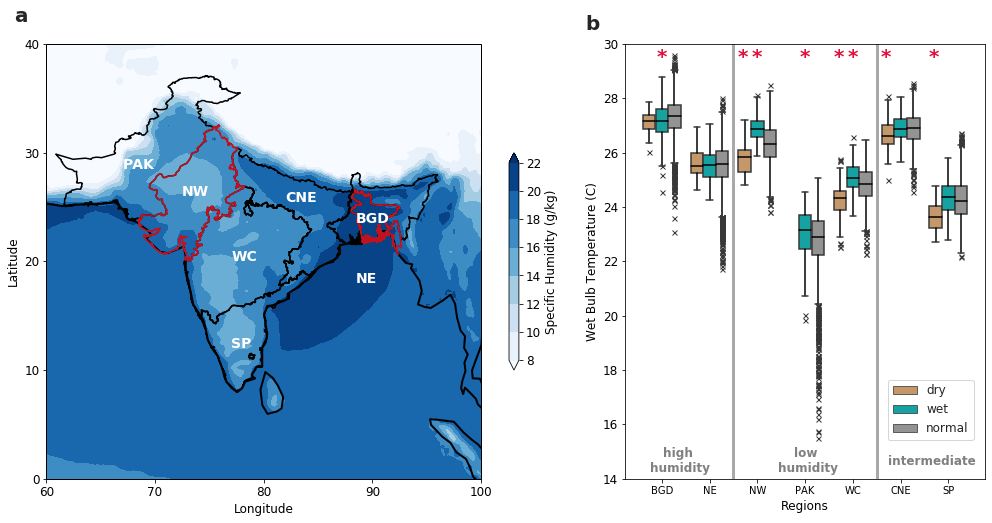

In [12]:
import shapefile as shp
import matplotlib.pyplot as plt
import matplotlib
import string
import seaborn as sns

CNE = shp.Reader(shp_datadir + 'Central_Northeast.shp')
HR = shp.Reader(shp_datadir + 'Hilly_Regions.shp')
NW = shp.Reader(shp_datadir + 'Northwest.shp')
SP = shp.Reader(shp_datadir + 'South_Peninsular.shp')
WC = shp.Reader(shp_datadir + 'West_Central.shp')
NE = shp.Reader(shp_datadir + 'Northeast.shp')
bgd = shp.Reader(shp_datadir + 'bangladesh.shp')
pak = shp.Reader(shp_datadir + 'pakistan.shp')

regions = [CNE, NW, SP, WC, NE, bgd, pak]
masks = [CNE_mask, NW_mask, SP_mask, WC_mask, NE_mask, bgd_mask, pak_mask]

font_size = 12

lon = q_unique.longitude
lat = q_unique.latitude

levels = np.arange(8,22+2,2)

fig = plt.figure(figsize = (17,8))

gs = fig.add_gridspec(1,5)
ax1 = fig.add_subplot(gs[0:3], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[3:6])

for i in range(len(masks)):
    
    sf = regions[i]
    
    if i == 1 or i == 5:
        c = '#c1121f'
        zord = 8
        size = 20
    else:
        c = 'k'
        zord = 1
        size = 20
        
    for shape in sf.shapeRecords():
        for i in range(len(shape.shape.parts)):
            i_start = shape.shape.parts[i]
            if i==len(shape.shape.parts)-1:
                i_end = len(shape.shape.points)
            else:
                i_end = shape.shape.parts[i+1]
            x = [i[0] for i in shape.shape.points[i_start:i_end]]
            y = [i[1] for i in shape.shape.points[i_start:i_end]]
            ax1.plot(x,y, markersize = size,color = c, zorder = zord)
            
# Add annotations for all regions            
ax1.text(72.5, 26, 'NW', size=14, c = 'white', weight='bold', zorder = 10)
ax1.text(88.5, 23.5, 'BGD', size=14,c = 'white', weight='bold', zorder = 10)
ax1.text(67, 28.5, 'PAK', size=14,c = 'white', weight='bold', zorder = 10)
ax1.text(77, 20, 'WC', size=14,c = 'white', weight='bold', zorder = 10)
ax1.text(77, 12, 'SP', size=14,c = 'white', weight='bold', zorder = 10)
ax1.text(82, 25.5, 'CNE', size=14,c = 'white', weight='bold', zorder = 10)
ax1.text(88.5, 18, 'NE', size=14,c = 'white', weight='bold', zorder = 10)
            
q_map = ax1.contourf(q_monsoon_reg.longitude, q_monsoon_reg.latitude, 1000*q_monsoon_reg.q, cmap = 'Blues', levels = levels, extend = 'both')
ax1.coastlines(linewidth=2)
ax1.set_xticks([60,70,80,90,100], crs=ccrs.PlateCarree());
ax1.set_yticks([0, 10, 20, 30, 40], crs=ccrs.PlateCarree());
ax1.set_ylabel('Latitude', fontsize = font_size)
ax1.set_xlabel('Longitude', fontsize = font_size)

ax1.tick_params(axis='both', which='major', labelsize=font_size)

cbar = plt.colorbar(q_map, ax=ax1, shrink = 0.5,format = "%d",label = 'Specific Humidity (g/kg)')
tick_locator = ticker.MaxNLocator(nbins=9)
cbar.locator = tick_locator
cbar.update_ticks()

cbar.ax.tick_params(labelsize=font_size)
cbar.set_label(label = 'Specific Humidity (g/kg)', size = font_size)

# Plot B

sns.set_style("whitegrid")

light_frac = 0.85
palette = [lighten_color('peru', light_frac),lighten_color('teal', light_frac),lighten_color('grey', light_frac)]

sns.boxplot(x='region', y='TW', hue='event', data=all_reg_df, palette = palette, medianprops={"color": "k"}, flierprops={"marker": "x"}, whiskerprops={"color": "k"}, ax = ax2)

ax2.vlines(1.5, -10,50, color = 'darkgrey', linewidth = 3)
ax2.vlines(4.5, -10,50, color = 'darkgrey', linewidth = 3)

ax2.text(-0.24, 14.25, 'high \nhumidity', fontsize=font_size, fontweight = 'bold', color = 'grey', multialignment='center')
ax2.text(2.44, 14.25, 'low \nhumidity', fontsize=font_size, fontweight = 'bold', color = 'grey', multialignment='center')
ax2.text(4.73, 14.5, 'intermediate', fontsize=font_size, fontweight = 'bold', color = 'grey', multialignment='center')

plt.xlabel("Regions", fontsize = font_size)
plt.ylim([14,30])
plt.ylabel("Wet Bulb Temperature (C)", fontsize = font_size)
plt.legend(loc='lower right', bbox_to_anchor=(0.985,0.075), fontsize = font_size)

plt.yticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
ax2.set_xticklabels(['BGD','NE','NW','PAK','WC','CNE','SP'])
ax2.grid(False)

ax1.text(57, 42, string.ascii_lowercase[0], size=20, weight='bold')
ax2.text(-1.6, 30.5, string.ascii_lowercase[1], size=20, weight='bold')

# Add asterisks to indicate significance, where applicable
ast_height = 29.3
ax2.text(0,ast_height, '*', fontsize = 20, fontweight = 'bold', color = 'crimson', horizontalalignment = 'center') # BGD, wet
ax2.text(1.7,ast_height, '*', fontsize = 20, fontweight = 'bold', color = 'crimson', horizontalalignment = 'center') # NW, dry
ax2.text(2,ast_height, '*', fontsize = 20, fontweight = 'bold', color = 'crimson', horizontalalignment = 'center') # NW, wet
ax2.text(3,ast_height, '*', fontsize = 20, fontweight = 'bold', color = 'crimson', horizontalalignment = 'center') # PAK, wet
ax2.text(3.7,ast_height, '*', fontsize = 20, fontweight = 'bold', color = 'crimson', horizontalalignment = 'center') # WC, dry
ax2.text(4,ast_height, '*', fontsize = 20, fontweight = 'bold', color = 'crimson', horizontalalignment = 'center') # WC, wet
ax2.text(4.7,ast_height, '*', fontsize = 20, fontweight = 'bold', color = 'crimson', horizontalalignment = 'center') # CNE, dry
ax2.text(5.7,ast_height, '*', fontsize = 20, fontweight = 'bold', color = 'crimson', horizontalalignment = 'center') # SP, dry

plt.show()